In [1]:

import librosa
import librosa.display
import scipy
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
import math
from PyHa.statistics import *
from PyHa.IsoAutio import *
from PyHa.visualizations import *
from scipy.io import wavfile
import sounddevice as sd
from sklearn import decomposition
import time
import os


C:\Users\Jacob\miniconda3\envs\species-id\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Jacob\miniconda3\envs\species-id\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Jacob\miniconda3\envs\species-id\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Jacob\miniconda3\envs\species-id\lib\site-pack

(0.0, 10.0)

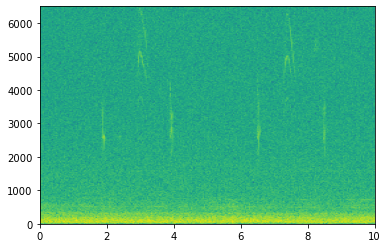

In [19]:
FS, SIGNAL = wavfile.read("California_Gnatcatcher.WAV")
SIGNAL_DOWNSAMPLED = scipy_signal.resample(SIGNAL,int(len(SIGNAL)*13000/FS))
plt.specgram(SIGNAL_DOWNSAMPLED,Fs=13000,NFFT=1024,noverlap=512,window=np.hanning(1024));
plt.xlim(0,10)

### Bandpass Filtering Functions

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Filtering Original Signal 

(0.0, 10.0)

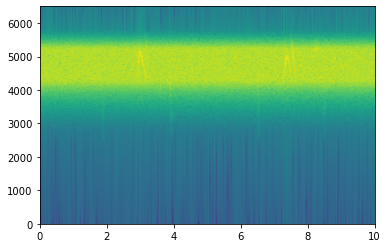

In [4]:
FILTERED_SIGNAL_DOWNSAMPLED = butter_bandpass_filter(SIGNAL_DOWNSAMPLED,4250,5250,13000,order = 11)
plt.specgram(FILTERED_SIGNAL_DOWNSAMPLED,Fs=13000,NFFT=1024,noverlap=512,window=np.hanning(1024));
plt.xlim(0,10)

In [5]:
SAMPLE_RATE, GNATCATCHER_TEMPLATE = wavfile.read("California_Gnatcatcher_Template.wav")
DOWNSAMPLED_SAMPLE_RATE = 13000
GNATCATCHER_TEMPLATE_DOWNSAMPLED = scipy_signal.resample(GNATCATCHER_TEMPLATE,int(len(GNATCATCHER_TEMPLATE)*DOWNSAMPLED_SAMPLE_RATE/SAMPLE_RATE))

C:\Users\Jacob\miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


(9310,)


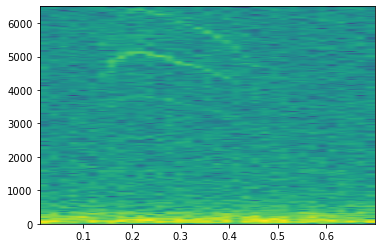

In [6]:
# Looks like I should isolate 0.05 to 0.45
plt.specgram(GNATCATCHER_TEMPLATE_DOWNSAMPLED,Fs=DOWNSAMPLED_SAMPLE_RATE,NFFT=512,noverlap=256,window=np.hanning(512));
print(GNATCATCHER_TEMPLATE_DOWNSAMPLED.shape)

### Filtering The Template

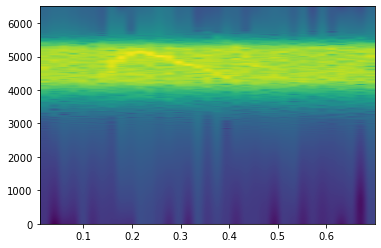

In [12]:
FILTERED_GNATCATCHER_TEMPLATE_DOWNSAMPLED = butter_bandpass_filter(GNATCATCHER_TEMPLATE_DOWNSAMPLED,4250,5250,13000,order = 11)
plt.specgram(FILTERED_GNATCATCHER_TEMPLATE_DOWNSAMPLED,Fs=DOWNSAMPLED_SAMPLE_RATE,NFFT=512,noverlap=256,window=np.hanning(512));

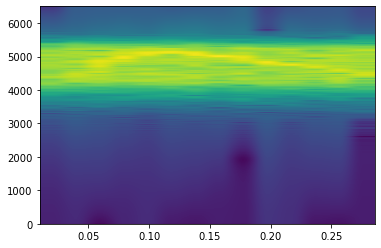

In [14]:
# After filtering, it looks like the template is better suited between 0.1 and 0.4s
FILTERED_GNATCATCHER_TEMPLATE_DOWNSAMPLED = FILTERED_GNATCATCHER_TEMPLATE_DOWNSAMPLED[int(0.1*13000):int(0.4*13000)]
plt.specgram(FILTERED_GNATCATCHER_TEMPLATE_DOWNSAMPLED,Fs=DOWNSAMPLED_SAMPLE_RATE,NFFT=512,noverlap=256,window=np.hanning(512));

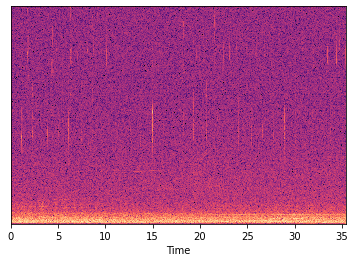

In [8]:
signal_spec = np.abs(librosa.stft(SIGNAL_DOWNSAMPLED))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(signal_spec,ref=np.max), x_axis='time', ax=ax)

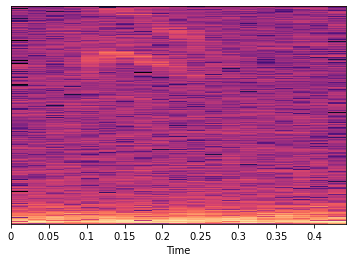

In [9]:
template_spec = np.abs(librosa.stft(GNATCATCHER_TEMPLATE_DOWNSAMPLED))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(template_spec,ref=np.max), x_axis='time', ax=ax)

In [16]:
filtered_signal_spec = np.abs(librosa.stft(FILTERED_SIGNAL_DOWNSAMPLED))
filtered_template_spec = np.abs(librosa.stft(FILTERED_GNATCATCHER_TEMPLATE_DOWNSAMPLED))

In [10]:
def autocorrelation_spec1D(signal):
    return scipy.signal.correlate2d(signal-np.mean(signal),signal-np.mean(signal),boundary="symm",mode="valid")
def normalized_cross_correlation_2D(signal, template, autocorrelation_scalar, template_mean, template_std_dev):
    signal_mean = np.mean(signal)
    corr = scipy.signal.correlate2d(signal-signal_mean,template-template_mean,boundary="symm",mode="valid")
    signal_std_dev = np.std(signal)
    # I am calculating this n incorrectly
    n = max(signal.shape[0]*signal.shape[1],template.shape[0]*template.shape[1])
    normalized_corr = (corr[0])/(n*signal_std_dev*template_std_dev)
    return normalized_corr

709741346523.7009
0.013507099576832934


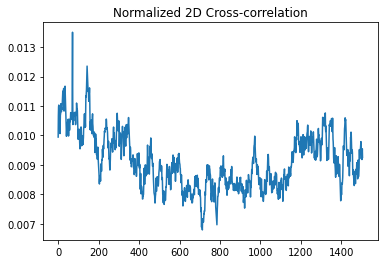

In [11]:
autocorrelation_scalar = max(autocorrelation_spec1D(template_spec))
print(autocorrelation_scalar[0])
template_mean = np.mean(template_spec)
template_std_dev = np.std(template_spec)
normalized_corr = normalized_cross_correlation_2D(signal_spec,template_spec,autocorrelation_scalar[0],template_mean,template_std_dev)
plt.plot(normalized_corr)
plt.title("Normalized 2D Cross-correlation")
print(max(normalized_corr))

0.010212590609225403


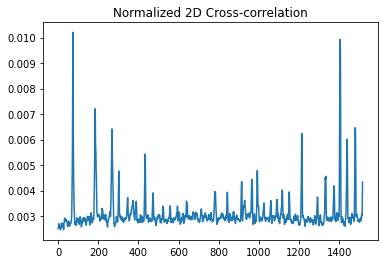

In [17]:
autocorrelation_scalar_2 = max(autocorrelation_spec1D(filtered_template_spec))
filtered_template_mean = np.mean(filtered_template_spec)
filtered_template_std_dev = np.std(filtered_template_spec)
normalized_corr_2 = normalized_cross_correlation_2D(filtered_signal_spec,filtered_template_spec,autocorrelation_scalar[0],filtered_template_mean,filtered_template_std_dev)
plt.plot(normalized_corr_2)
plt.title("Normalized 2D Cross-correlation")
print(max(normalized_corr_2))

In [32]:
isolation_parameters = {
    "technique" : "steinberg",
    "threshold_type" : "median",
    "threshold_const" : 2.0,
    "threshold_min" : 0,
    "bi_directional_jump" : 0.15
}

In [33]:
clip_df = steinberg_isolate(normalized_corr_2,FILTERED_SIGNAL_DOWNSAMPLED,13000,"C:\\Users\\Jacob\\Desktop\\Cross_Correlation\\Python","California_Gnatcatcher.WAV",isolation_parameters)

In [34]:
clip_df

,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,OFFSET,DURATION,MANUAL ID
0,C:\Users\Jacob\Desktop\Cross_Correlation\Python,California_Gnatcatcher.WAV,0,60.0,13000,2.696769,0.418615,bird
1,C:\Users\Jacob\Desktop\Cross_Correlation\Python,California_Gnatcatcher.WAV,0,60.0,13000,7.085538,0.418615,bird
2,C:\Users\Jacob\Desktop\Cross_Correlation\Python,California_Gnatcatcher.WAV,0,60.0,13000,10.406769,0.339538,bird
3,C:\Users\Jacob\Desktop\Cross_Correlation\Python,California_Gnatcatcher.WAV,0,60.0,13000,47.810154,0.339538,bird
4,C:\Users\Jacob\Desktop\Cross_Correlation\Python,California_Gnatcatcher.WAV,0,60.0,13000,55.282923,0.497692,bird
5,C:\Users\Jacob\Desktop\Cross_Correlation\Python,California_Gnatcatcher.WAV,0,60.0,13000,56.706308,0.379077,bird
6,C:\Users\Jacob\Desktop\Cross_Correlation\Python,California_Gnatcatcher.WAV,0,60.0,13000,58.327385,0.379077,bird


In [35]:
clip_df.to_csv("gnatcatcher_test_3.csv",index=False)